# <font size="6">Libraries</font>

In [1]:
import torch

import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
print('torch version (<2): ', torch.__version__)

import ptls
from ptls.frames import PtlsDataModule
from ptls.frames.coles import losses, sampling_strategies
from ptls.frames.coles import split_strategy

from ptls.frames.inference_module import InferenceModule

from ptls.nn.seq_encoder import agg_feature_seq_encoder
from ptls.nn import RnnSeqEncoder, TrxEncoder, Head
from ptls.nn.seq_encoder.agg_feature_seq_encoder import AggFeatureSeqEncoder

from ptls.data_load.datasets import AugmentationDataset, MemoryMapDataset
from ptls.data_load.augmentations import AllTimeShuffle, DropoutTrx
from ptls.data_load.datasets.parquet_dataset import ParquetDataset
from ptls.data_load.iterable_processing import SeqLenFilter, FeatureFilter
from ptls.data_load.datasets import parquet_file_scan
from ptls.data_load.datasets import ParquetDataset, ParquetFiles, AugmentationDataset
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter, FeatureFilter
from ptls.data_load.augmentations import DropoutTrx
from ptls.data_load.datasets import inference_data_loader
from ptls.data_load.utils import collate_feature_dict

from functools import partial

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import hydra
import seaborn as sns
import umap

import pprint
from pygments import highlight
from pygments.lexers import YamlLexer
from pygments.formatters import HtmlFormatter
import IPython

torch version (<2):  1.12.1+cu102


In [2]:
plt.style.use('default')
sns.set(rc={'figure.figsize':(8, 6)})
sns.set_style('white')
sns.despine()

<Figure size 800x600 with 0 Axes>

# <font size="6">Data</font>

In [3]:
pd.read_parquet('src/ptls-experiments/scenario_rosbank/data/train_trx.parquet')

,cl_id,amount,event_time,mcc,channel_type,currency,trx_category,trx_count,target_flag,target_sum
0,10018,"[10.609081944147828, 10.596659732783579, 10.81...","[17120.13773148148, 17133.417800925927, 17134....","[14, 3, 14, 3, 2, 19, 14, 3, 14, 3, 6, 14, 10,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[6, 4, 6, 4, 2, 2, 6, 4, 6, 4, 2, 6, 6, 6, 6]",15,0.0,0.000000
1,10030,"[4.61512051684126, 6.90875477931522, 10.598857...","[17140.75, 17140.75, 17144.75, 17146.75, 17146...","[10, 10, 22, 2, 26, 7, 15, 15, 4, 4, 4, 14, 2,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 4, ...",42,1.0,59.509998
2,10038,"[7.4127640174265625, 7.370230641807081, 7.8180...","[17300.75, 17300.75, 17300.75, 17301.524780092...","[2, 2, 2, 3, 3, 5, 3, 9, 2, 23, 9, 2, 9, 5, 3,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 3, 3, 2, 4, 2, 2, 2, 2, 2, 2, 2, 3, ...",111,0.0,0.000000
3,10057,"[7.494708263135679, 7.736394428979239, 10.7789...","[17150.75, 17150.75, 17152.75, 17153.75, 17154...","[7, 22, 3, 7, 3, 5, 3, 23, 16, 3, 2, 36, 5, 3,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 5, 2, 5, 2, 4, 2, 2, 4, 2, 2, 2, 5, 2, ...",61,1.0,62961.308594
4,10062,"[8.31898612539206, 8.824824939175638, 6.509067...","[17142.75, 17142.75, 17142.75, 17143.75, 17143...","[81, 16, 38, 39, 12, 12, 3, 25, 8, 6, 6, 12, 2...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, ...",82,1.0,107126.351562
...,...,...,...,...,...,...,...,...,...,...
9712,9971,"[6.726233402358747, 8.920656296853728, 8.10198...","[17136.75, 17137.75, 17137.75, 17137.75, 17139...","[21, 2, 42, 27, 7, 2, 4, 4, 2, 32, 20, 18, 22,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",66,NaN,NaN
9713,998,"[8.070906088787819, 6.92706759001451, 6.287858...","[17341.75, 17341.75, 17342.75, 17342.75, 17344...","[90, 20, 11, 6, 3, 30, 30, 9, 2, 32, 20, 17, 5...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 4, 10, 10, 2, 2, 2, 2, 2, 2, 2, 2...",78,NaN,NaN
9714,9982,"[9.559658319461347, 7.937731775260109, 8.29429...","[17371.75, 17371.75, 17372.369224537037, 17372...","[7, 185, 3, 6, 44, 2, 7, 28, 31, 4, 3, 5, 3, 2...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, ...",79,NaN,NaN
9715,9997,"[6.85751406254539, 4.356708826689592, 5.159055...","[17095.75, 17095.75, 17095.75, 17095.75, 17096...","[50, 20, 6, 22, 104, 2, 2, 41, 2, 5, 5, 5, 196...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",143,NaN,NaN


# <font size="6">Load config</font>

In [4]:
with open('src/ptls-experiments/scenario_rosbank/conf/mles_params.yaml', 'r') as file:
    code = file.read()

IPython.display.HTML(highlight(code, YamlLexer(), HtmlFormatter()))

In [5]:
conf = OmegaConf.load('src/ptls-experiments/scenario_rosbank/conf/mles_params.yaml')
module_conf = conf['data_module']

data_conf = OmegaConf.load('src/ptls-experiments/scenario_rosbank/conf/dataset_unsupervised/parquet.yaml')
train_path = 'src/ptls-experiments/scenario_rosbank/data/train_trx.parquet'
data_conf['train']['data']['data']['data_files']['file_path'] = train_path
data_conf['valid']['data']['data_files']['file_path'] = train_path

module_conf['train_data']['data'] = data_conf['train']
module_conf['valid_data']['data'] = data_conf['valid']

# <font size="6">Data module and model</font>

In [6]:
data_module = hydra.utils.instantiate(module_conf)

model = hydra.utils.instantiate(conf['pl_module'])

model

CoLESModule(
  (_loss): ContrastiveLoss()
  (_seq_encoder): RnnSeqEncoder(
    (trx_encoder): TrxEncoder(
      (embeddings): ModuleDict(
        (mcc): NoisyEmbedding(
          100, 24, padding_idx=0
          (dropout): Dropout(p=0, inplace=False)
        )
        (channel_type): NoisyEmbedding(
          4, 4, padding_idx=0
          (dropout): Dropout(p=0, inplace=False)
        )
        (currency): NoisyEmbedding(
          4, 4, padding_idx=0
          (dropout): Dropout(p=0, inplace=False)
        )
        (trx_category): NoisyEmbedding(
          10, 4, padding_idx=0
          (dropout): Dropout(p=0, inplace=False)
        )
      )
      (numeric_values): ModuleDict(
        (amount): IdentityScaler()
      )
      (numerical_batch_norm): RBatchNormWithLens(
        (bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (seq_encoder): RnnEncoder(
      (rnn): LSTM(37, 1024, batch_first=True)
      (reducer): LastStepEncoder()

# <font size="6">Training</font>

In [7]:
logger = TensorBoardLogger('src/ptls-experiments/scenario_rosbank/lightning_logs',
                           name='Coles')

conf['trainer']['num_sanity_val_steps'] = 0

trainer = pl.Trainer(
     **conf['trainer'],
    logger = logger
)

trainer.fit(model, data_module)
print(trainer.logged_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 4.4 M 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0     
-------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.430    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

{'loss': tensor(13.6674), 'seq_len': tensor(58.9750), 'recall_top_k': tensor(0.8790)}


# <font size="6">Inference</font>

In [8]:
iterable_inference_dataset = ParquetDataset(
    data_files=ParquetFiles(['src/ptls-experiments/scenario_rosbank/data/train_trx.parquet',
                             'src/ptls-experiments/scenario_rosbank/data/test_trx.parquet'],                                                     
                            ).data_files,
    i_filters=[FeatureFilter(['cl_id', 'target_flag'])],
)

inference_dl = torch.utils.data.DataLoader(
    dataset=iterable_inference_dataset,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=128,
    num_workers=0,
)

mod = InferenceModule(model, pandas_output=True, model_out_name='emb')

pred = pl.Trainer(gpus=1).predict(mod, inference_dl)

embeddings_train_test = pd.concat(pred, axis=0)

/home/jovyan/.local/share/virtualenvs/ptls-experiments-Xgdpvmv-/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jovyan/.local/share/virtualenvs/ptls-experiments-Xgdpvmv-/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

/home/jovyan/.local/share/virtualenvs/ptls-experiments-Xgdpvmv-/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


# <font size="6">Reverse engineering</font>

In [9]:
embeddings_train_test = embeddings_train_test.sort_values(by='cl_id').reset_index().drop(columns=['index'])
embeddings_train_test

,cl_id,target_flag,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,...,emb_1014,emb_1015,emb_1016,emb_1017,emb_1018,emb_1019,emb_1020,emb_1021,emb_1022,emb_1023
0,0,0.0,0.012818,-0.005530,0.269331,-0.274468,-0.051850,-0.001597,0.008561,-0.055900,...,-0.001286,-0.001371,-0.007626,-0.002180,0.000212,-0.000393,0.007879,-0.039152,-0.018318,0.004272
1,1,0.0,0.072499,-0.009095,0.014323,-0.799587,-0.040203,-0.000275,-0.000031,-0.025105,...,-0.003662,-0.000496,0.000065,-0.000532,-0.000871,-0.011582,0.000136,-0.010826,0.000743,0.000527
2,10,0.0,0.068524,-0.023968,0.976224,-0.289610,-0.071920,0.000032,0.000527,-0.111118,...,-0.002408,-0.000030,-0.000326,-0.000280,-0.000299,0.000062,0.000029,-0.065920,-0.000311,0.000029
3,100,1.0,0.072801,-0.007956,0.171038,-0.671441,-0.135467,0.000055,0.000220,-0.041433,...,-0.000532,-0.000310,-0.000295,-0.000436,-0.001621,-0.001304,0.000058,-0.019069,0.000723,0.000089
4,1000,1.0,0.055143,-0.161859,0.686616,-0.805538,-0.063274,-0.000018,-0.000161,-0.068085,...,-0.000753,-0.000104,-0.000181,-0.000250,-0.000117,-0.000472,0.000080,-0.040966,0.000036,0.000174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10212,9995,0.0,0.128346,-0.023063,0.266074,-0.691510,-0.093533,0.000016,0.000236,-0.106103,...,-0.006936,-0.000042,-0.000066,-0.000510,-0.002164,-0.000333,0.000025,-0.016320,0.001000,0.000362
10213,9996,NaN,0.040457,-0.113130,0.517633,-0.437813,-0.197168,-0.000030,0.000282,-0.025947,...,-0.024366,-0.000286,-0.000208,-0.000433,-0.001319,-0.000964,0.000069,-0.041608,0.000266,0.002865
10214,9997,NaN,0.602891,-0.021870,0.314552,-0.657117,-0.161261,0.000223,-0.000045,-0.051479,...,-0.002639,-0.000056,0.000080,-0.000470,-0.000698,0.000159,0.000024,-0.016677,0.000339,0.000072
10215,9998,0.0,0.032421,-0.108840,0.433727,-0.600363,-0.056160,-0.000069,0.000135,-0.040917,...,-0.001919,-0.000179,-0.000028,-0.000412,-0.000755,-0.001091,0.000070,-0.010968,0.000405,0.000330


/home/jovyan/.local/share/virtualenvs/ptls-experiments-Xgdpvmv-/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


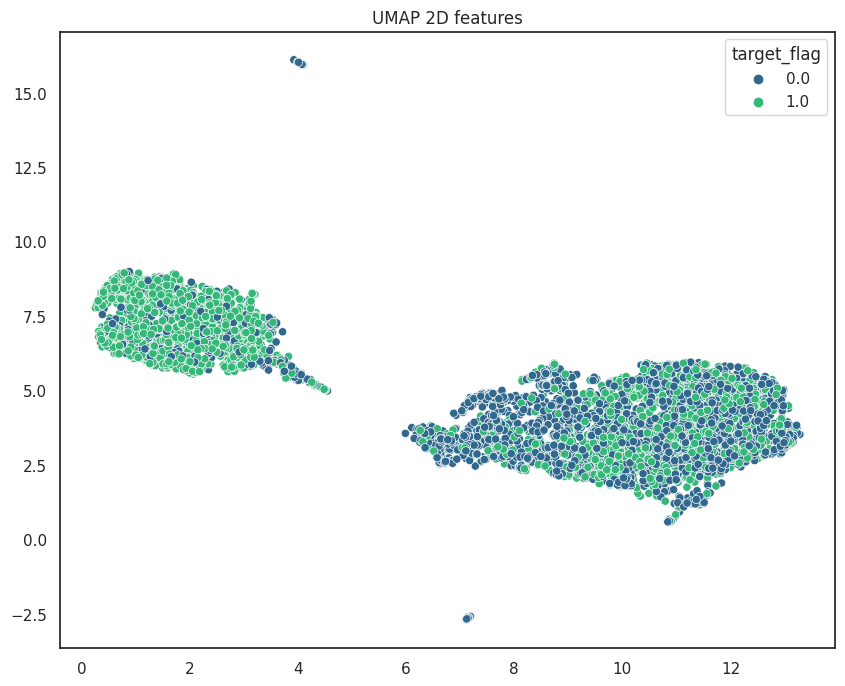

In [10]:
X = embeddings_train_test.dropna().drop(columns=['cl_id', 'target_flag'])
y = embeddings_train_test.dropna()['target_flag']

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='viridis')
plt.title('UMAP 2D features')
plt.show()